`Time` - Number of seconds elapsed between this transaction and the first transaction in the dataset

`V1-V28` - May be result of a PCA Dimensionality reduction to protect user identities and sensitive features

`Amount` - Transaction amount

`Class` - 1 for fraudulent transactions, 0 otherwise

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [2]:
data = pd.read_csv('creditcard.csv')
data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0


# EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
data.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [5]:
print(f'{round(data['Class'].value_counts()[1] / len(data) * 100, 2)}% or {len(data.loc[data['Class'] == 1])} transactions are fraudulent.')

0.17% or 492 transactions are fraudulent.


Всего 492 записей мошеннических операций, чnо составляет 0,17% от общего числа транзакций.

## Distribution of data

Для визуализации данных в двумерном пространстве будет использована только часть данных в соотношении 1:5 - мошеннические и законные банковские операции соответственно.

In [6]:
fraud = data.loc[data['Class'] == 1].reset_index(drop=True)
true = data.loc[data['Class'] == 0].sample(len(fraud) * 5).reset_index(drop=True)

sampled_data = pd.concat([fraud, true], axis=0, ignore_index=True)
sampled_data.tail()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
2947,38554.0,1.334488,0.232368,-0.404510,0.174915,0.498275,0.232966,-0.075877,0.073222,-0.057380,...,-0.353337,-1.063667,-0.092865,-1.448587,0.405122,0.185260,-0.031411,0.002421,1.98,0
2948,67850.0,-1.230821,1.078259,1.834094,1.109636,-0.415936,-0.097442,0.147350,0.622905,-0.384013,...,-0.142625,-0.347122,-0.052441,0.374575,0.296338,-0.383558,0.227759,0.055067,29.99,0
2949,47365.0,1.512454,-0.977236,0.331649,-1.314198,-1.527207,-1.066262,-0.871747,-0.265903,-1.849820,...,-0.102934,0.087755,-0.049887,0.389649,0.503001,-0.084051,0.022740,0.018209,21.00,0
2950,14485.0,1.162463,-0.084011,0.870322,0.158787,-0.575669,-0.042212,-0.607919,0.073888,1.451323,...,0.013852,0.308749,0.000324,0.038787,0.109366,1.043280,-0.075576,-0.007668,14.95,0
2951,63613.0,1.131223,-0.193422,1.136305,1.162468,-0.885823,0.282911,-0.764200,0.338831,0.866215,...,-0.048341,-0.037059,-0.041674,-0.030055,0.381905,-0.401396,0.058967,0.021886,9.99,0


In [7]:
colors = ['#66c968', '#C96866']

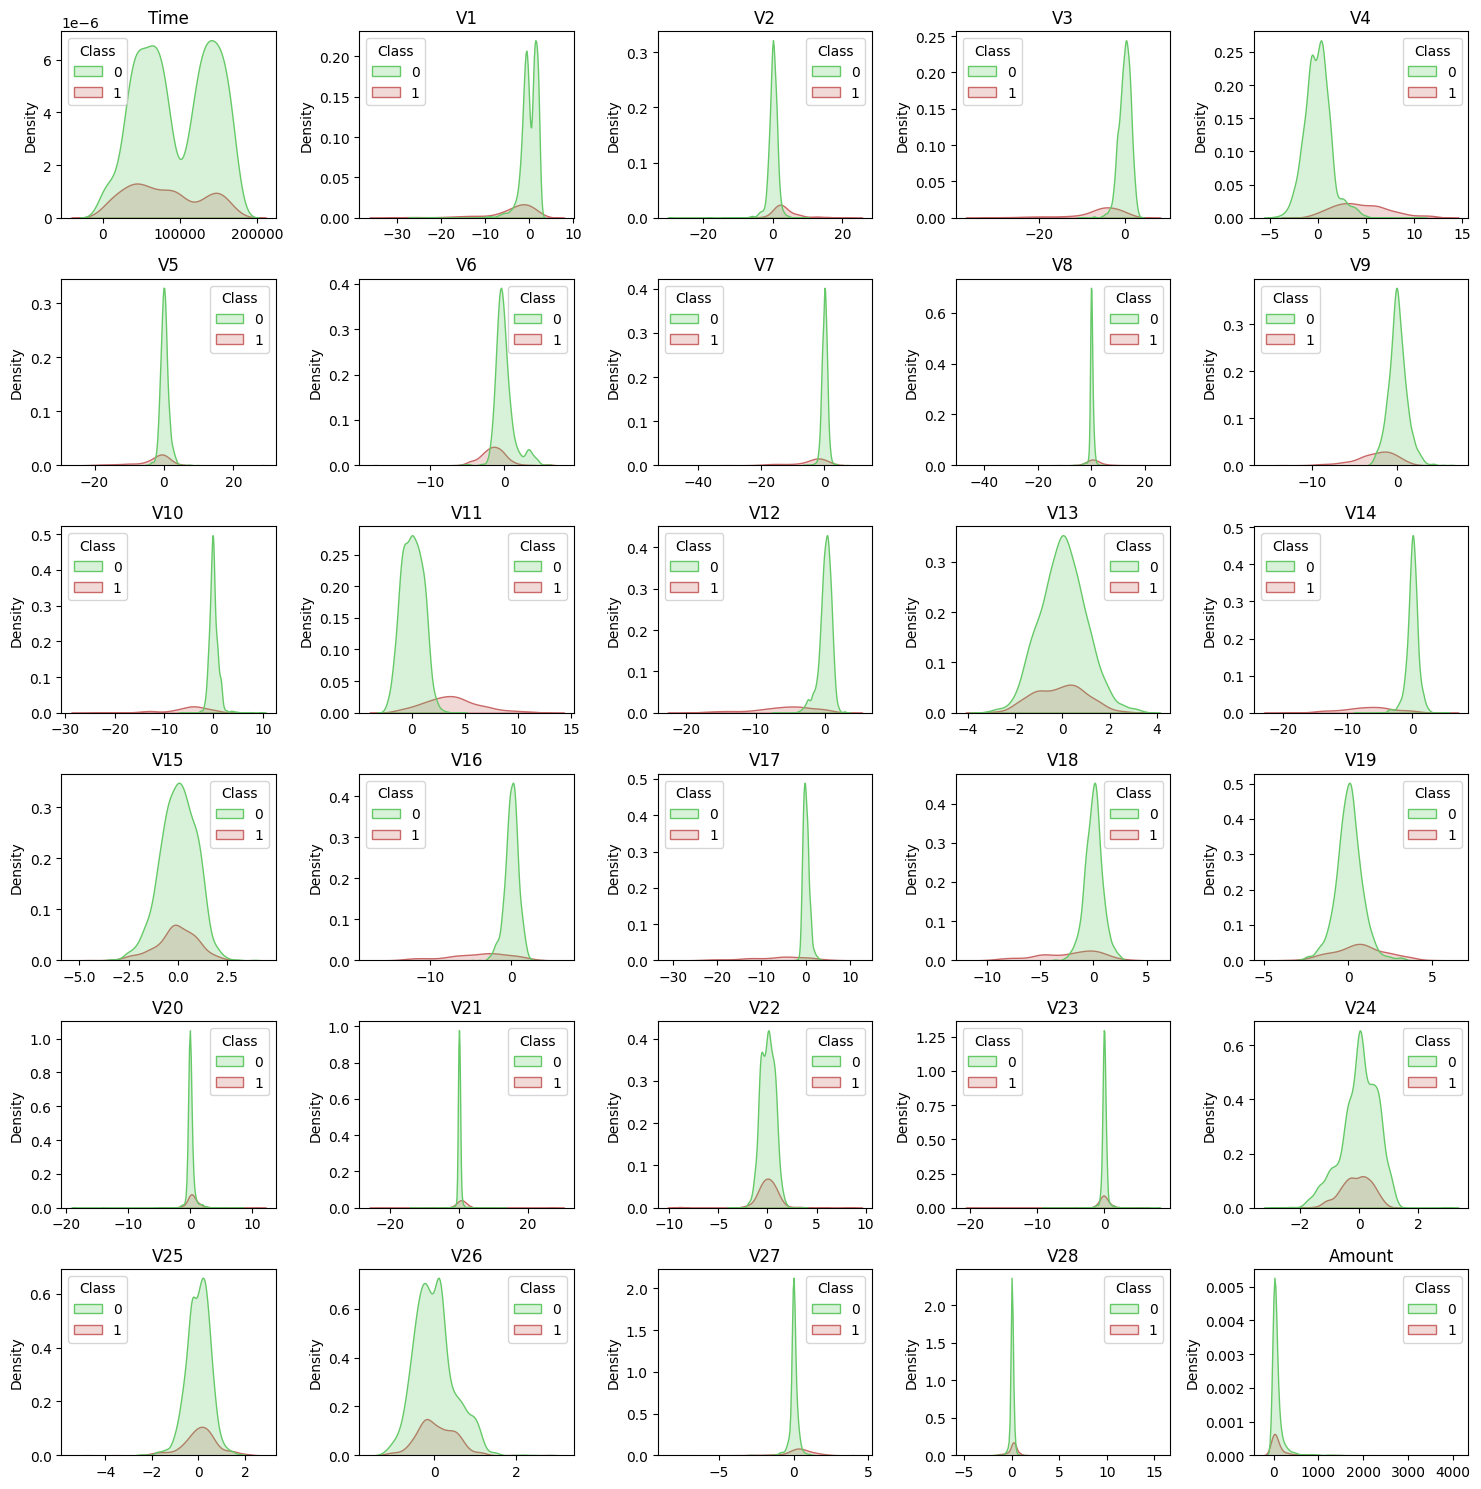

In [8]:
plt.figure(figsize=(15, 15))
dist = sampled_data.drop('Class', axis=1)

for i, col in enumerate(dist.columns):
    plt.subplot(6, 5, i+1).set_title(col)
    sns.kdeplot(data=dist,
                x=dist.columns[i],
                hue=sampled_data['Class'],
                fill=True,
                palette=colors)
    plt.xlabel('')

plt.tight_layout()
plt.show()

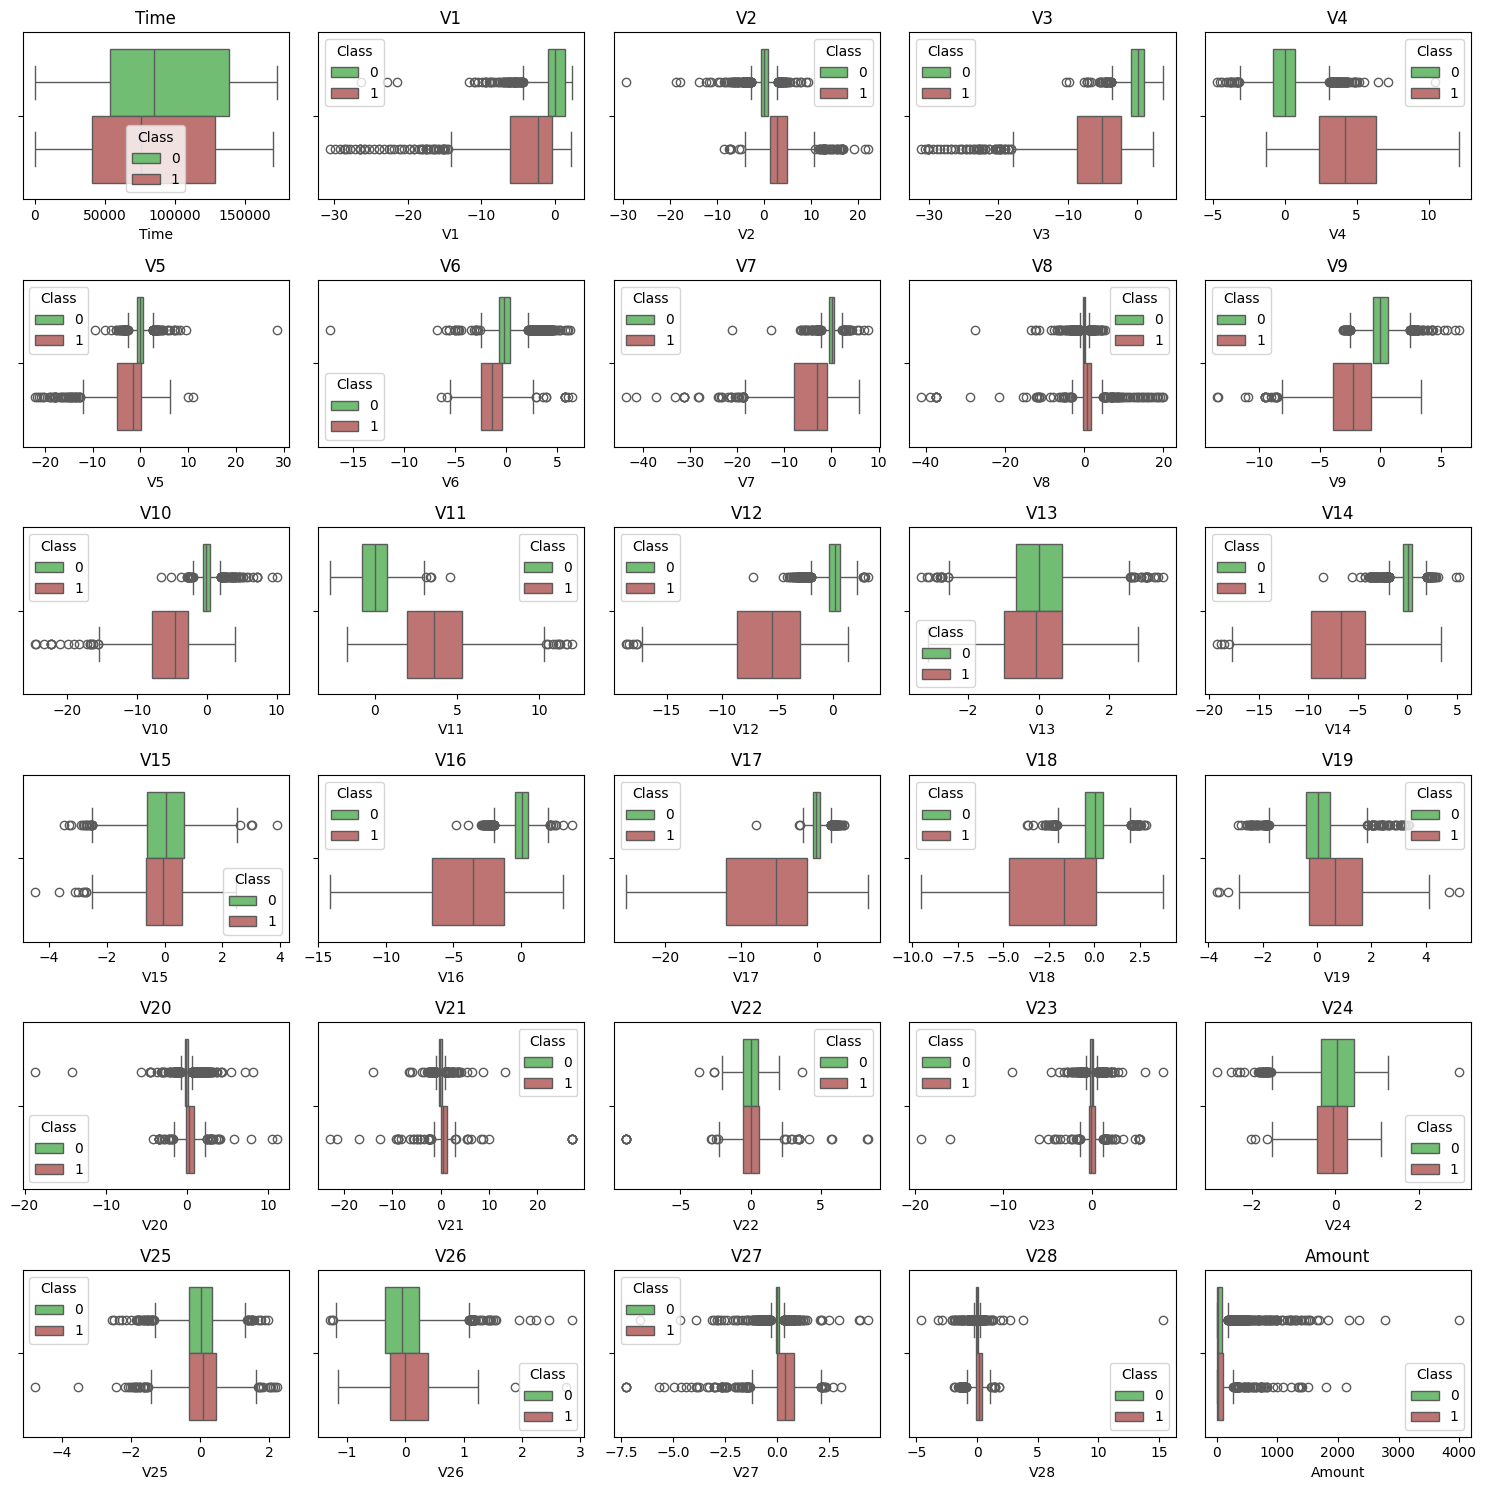

In [9]:
plt.figure(figsize=(15, 15))
for i, col in enumerate(dist.columns):
    plt.subplot(6, 5, i+1).set_title(col)
    sns.boxplot(data=dist,
                x=dist.columns[i],
                hue=sampled_data['Class'],
                palette=colors)

plt.tight_layout()
plt.show()

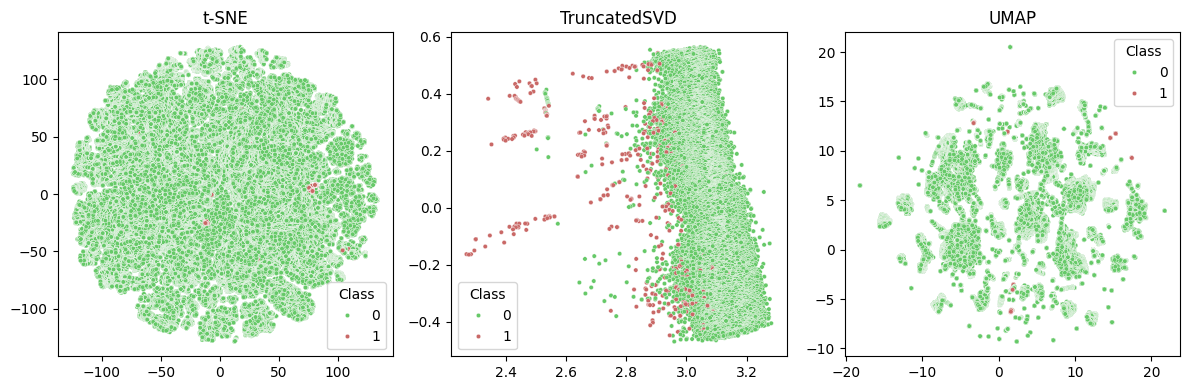

In [10]:
def decomp_plots(X_tsne, X_svd, X_umap, hue=data['Class']):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=hue, palette=colors, s=10)
    plt.title('t-SNE')

    plt.subplot(1, 3, 2)
    sns.scatterplot(x=X_svd[:, 0], y=X_svd[:, 1], hue=hue, palette=colors, s=10)
    plt.title('TruncatedSVD')

    plt.subplot(1, 3, 3)
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=hue, palette=colors, s=10)
    plt.title('UMAP')

    plt.tight_layout()
    plt.show()

X = data.drop(['Class'], axis=1)
y = data['Class']

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, random_state=RANDOM_SEED)
X_tsne = tsne.fit_transform(X_scaled)

svd = TruncatedSVD(n_components=2, random_state=RANDOM_SEED)
X_svd = svd.fit_transform(X_scaled)

umap = UMAP(n_components=2, random_state=RANDOM_SEED)
X_umap = umap.fit_transform(X_scaled)

decomp_plots(X_tsne, X_svd, X_umap)

# Models

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=RANDOM_SEED)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((213605, 30), (71202, 30), (213605,), (71202,))

## Isolation Forest

In [12]:
forest = IsolationForest(contamination=0.017, n_jobs=-1, random_state=RANDOM_SEED)
forest.fit(X_train)

y_forest = forest.predict(X_test)

# замена значений в полученном массиве
y_forest = np.where(y_forest == 1, 0, y_forest)
y_forest = np.where(y_forest == -1, 1, y_forest)

In [13]:
print(f'Предсказано аномальных значений: {sum(y_forest)}')
print(f'Доля предсказанных аномалий от общего числа транзаций: {round(sum(y_forest)/len(data), 6) * 100}%')
print(f'Доля аномалий от общего числа транзаций в тестовой выборке: {round(sum(y_test)/len(X_test)* 100, 4)}%')

Предсказано аномальных значений: 1215
Доля предсказанных аномалий от общего числа транзаций: 0.4266%
Доля аномалий от общего числа транзаций в тестовой выборке: 0.1727%


In [14]:
print(classification_report(y_test, y_forest))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71079
           1       0.07      0.72      0.13       123

    accuracy                           0.98     71202
   macro avg       0.54      0.85      0.56     71202
weighted avg       1.00      0.98      0.99     71202



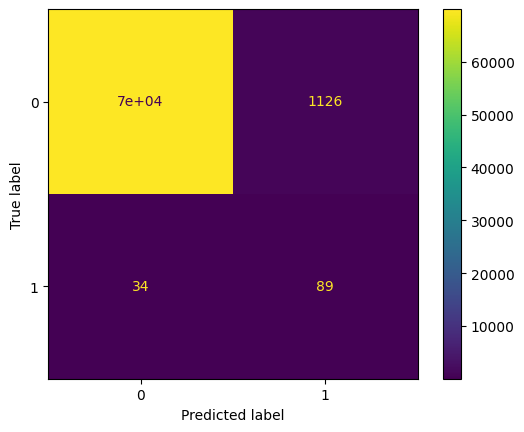

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_forest)
plt.show()

In [17]:
def compare_plot(y_pred):
    X_test_svd = svd.fit_transform(X_test)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_test_svd[:, 0], y=X_test_svd[:, 1], hue=y_pred, palette=colors, s=10)
    plt.title('Predicted data with TruncatedSVD')

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_svd[:, 0], y=X_svd[:, 1], hue=data['Class'], palette=colors, s=10)
    plt.title('Original data with TruncatedSVD')

    plt.tight_layout()
    plt.show()

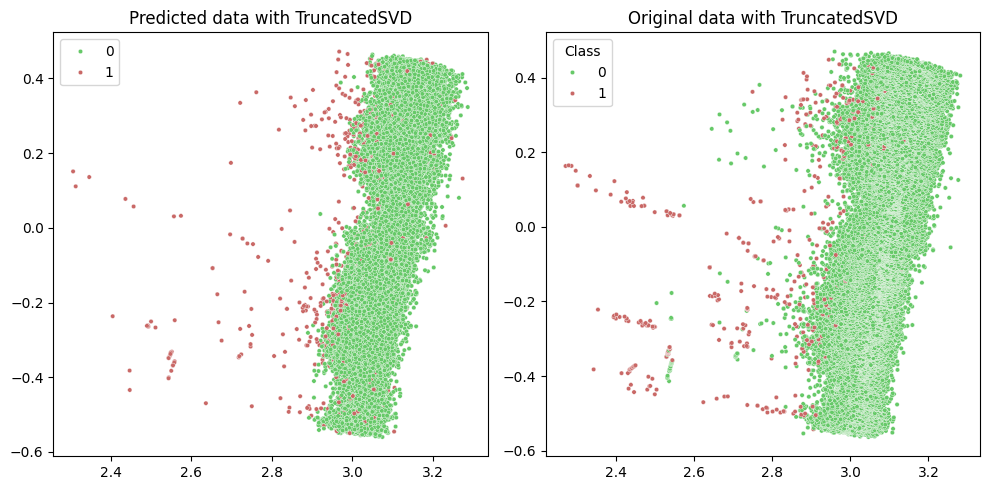

In [17]:
compare_plot(y_forest)

Наблюдается значительное число ложно-мошеннических транзакций.

## One-Class SVM

In [21]:
svm = OneClassSVM(nu=0.017)
svm.fit(X_train)

y_svm = svm.predict(X_test)

# замена значений в полученном массиве
y_svm = np.where(y_svm == 1, 0, y_svm)
y_svm = np.where(y_svm == -1, 1, y_svm)

In [22]:
print(f'Предсказано аномальных значений: {sum(y_svm)}')
print(f'Доля предсказанных аномалий от общего числа транзаций: {round(sum(y_svm)/len(data) * 100, 4)}%')
print(f'Доля аномалий от общего числа транзаций в тестовой выборке: {round(sum(y_test)/len(X_test) * 100, 4)}%')

Предсказано аномальных значений: 1267
Доля предсказанных аномалий от общего числа транзаций: 0.4449%
Доля аномалий от общего числа транзаций в тестовой выборке: 0.1727%


In [23]:
print(classification_report(y_test, y_svm))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71079
           1       0.06      0.67      0.12       123

    accuracy                           0.98     71202
   macro avg       0.53      0.82      0.55     71202
weighted avg       1.00      0.98      0.99     71202



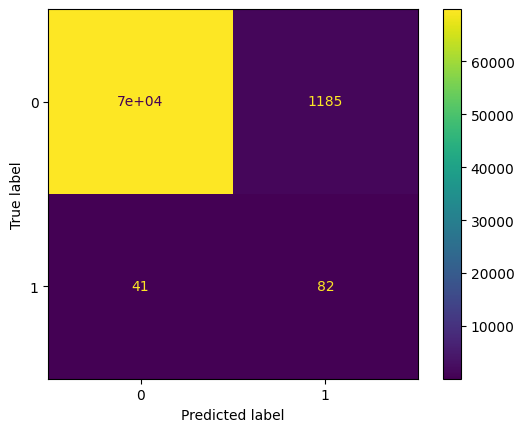

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, y_svm)
plt.show()

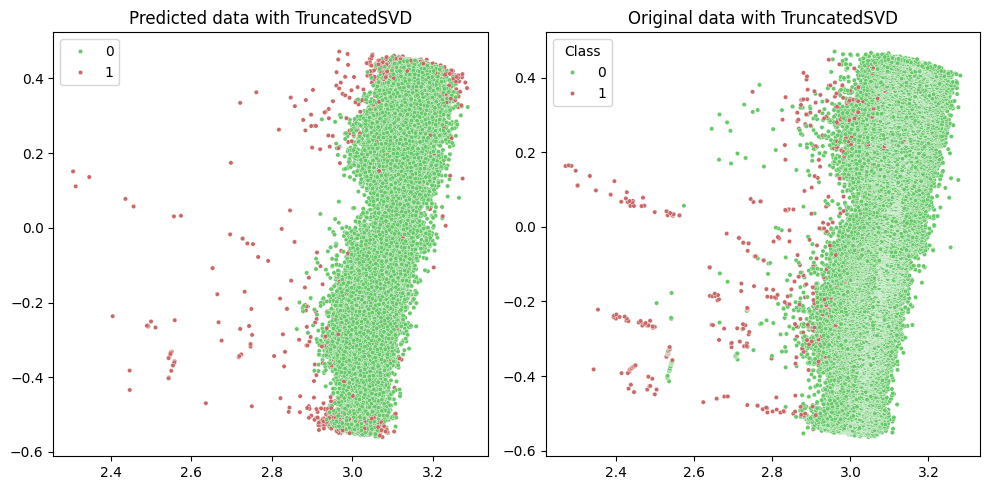

In [25]:
compare_plot(y_svm)

Тоже перебор.

## Local Outlier Factor

In [18]:
lof = LocalOutlierFactor(contamination=0.017, n_jobs=-1)

y_lof = lof.fit_predict(X_test)

# замена значений в полученном массиве
y_lof = np.where(y_lof == 1, 0, y_lof)
y_lof = np.where(y_lof == -1, 1, y_lof)

In [19]:
print(f'Предсказано аномальных значений: {sum(y_lof)}')
print(f'Доля предсказанных аномалий от общего числа транзаций: {round(sum(y_lof)/len(data) * 100, 4)}%')
print(f'Доля аномалий от общего числа транзаций в тестовой выборке: {round(sum(y_test)/len(X_test) * 100, 4)}%')

Предсказано аномальных значений: 1211
Доля предсказанных аномалий от общего числа транзаций: 0.4252%
Доля аномалий от общего числа транзаций в тестовой выборке: 0.1727%


In [20]:
print(classification_report(y_test, y_lof))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     71079
           1       0.03      0.25      0.05       123

    accuracy                           0.98     71202
   macro avg       0.51      0.62      0.52     71202
weighted avg       1.00      0.98      0.99     71202



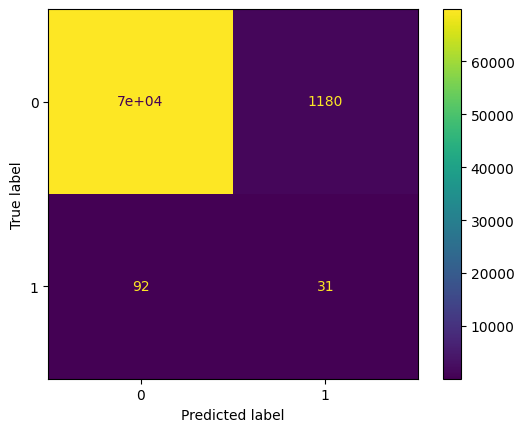

In [21]:
ConfusionMatrixDisplay.from_predictions(y_test, y_lof)
plt.show()

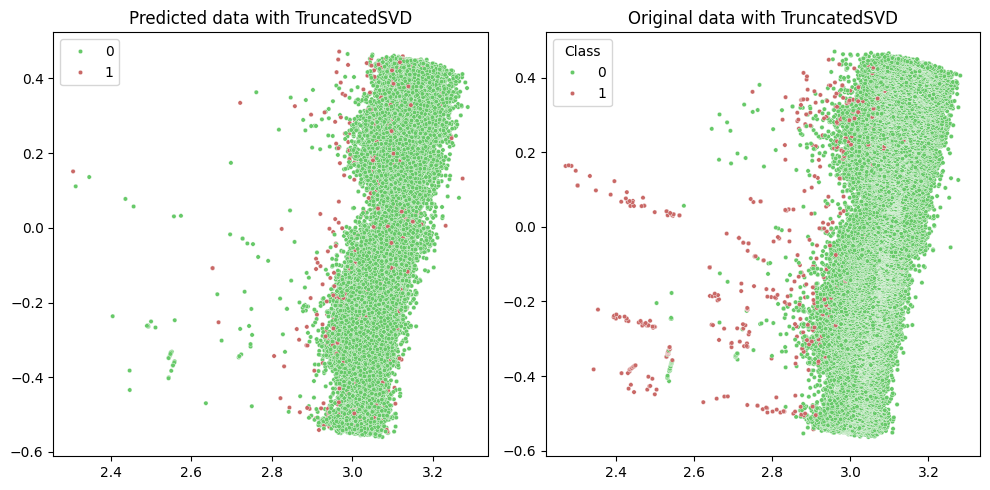

In [22]:
compare_plot(y_lof)

В данном случае результат противоположный (но не с точки зрения его точности) - модель не распознает множество мошеннических транзакций.

## DBSCAN

In [12]:
outlier_percentage = 1.

num_clusters = []
anomaly_percentage = []

eps = 0.05
eps_history = [eps]
while outlier_percentage > 0.17:
    dbscan = DBSCAN(eps=eps).fit(X_test)
    labels = dbscan.labels_
    num_clusters.append(len(np.unique(labels))-1)
    labels = np.array([1 if label == -1 else 0 for label in labels])
    outlier_percentage = sum(labels == 1) / len(labels)
    eps += 0.05
    eps_history.append(eps)
    anomaly_percentage.append(outlier_percentage)

dbscan = DBSCAN(eps)
dbscan.fit(X_test)
y_dbscan = np.array([1 if label == -1 else 0 for label in dbscan.labels_])

In [13]:
print(f'Предсказано аномальных значений: {sum(y_dbscan)}')
print(f'Доля предсказанных аномалий от общего числа транзаций: {round(sum(y_dbscan)/len(data) * 100, 4)}%')
print(f'Доля аномалий от общего числа транзаций в тестовой выборке: {round(sum(y_test)/len(X_test) * 100, 4)}%')

Предсказано аномальных значений: 805
Доля предсказанных аномалий от общего числа транзаций: 0.2826%
Доля аномалий от общего числа транзаций в тестовой выборке: 0.1727%


In [14]:
print(classification_report(y_test, y_dbscan))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     71079
           1       0.11      0.72      0.19       123

    accuracy                           0.99     71202
   macro avg       0.55      0.85      0.59     71202
weighted avg       1.00      0.99      0.99     71202



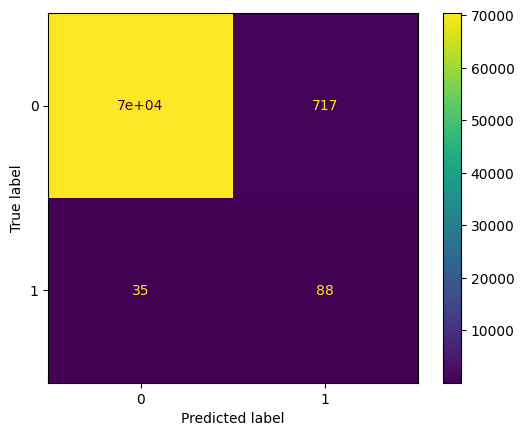

In [15]:
ConfusionMatrixDisplay.from_predictions(y_test, y_dbscan)
plt.show()

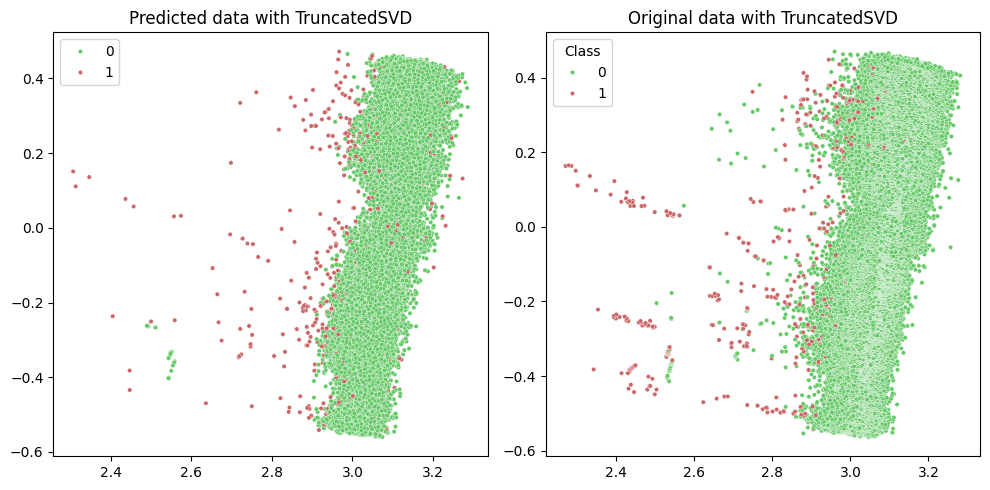

In [18]:
compare_plot(y_dbscan)

Данный метод отработал лучше всех.